In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [2]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [3]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-54-152-212-69.compute-1.amazonaws.com:50070
YARN: http://ec2-54-152-212-69.compute-1.amazonaws.com:8088
Spark UI: http://ec2-54-152-212-69.compute-1.amazonaws.com:20888/proxy/application_1589032052307_0001


# Ephemeral local HDFS

In [4]:
! hdfs dfs -df -h

Filesystem                                  Size     Used  Available  Use%
hdfs://ip-172-31-26-238.ec2.internal:8020  4.3 T  444.5 M      4.3 T    0%


In [5]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2020-05-09 13:47 /tmp
drwxr-xr-x   - hdfs hadoop          0 2020-05-09 13:47 /user
drwxr-xr-x   - hdfs hadoop          0 2020-05-09 13:47 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [6]:
! aws s3 ls s3://ydatazian

2020-05-09 13:43:02       1732 bootstrap.sh
2020-05-07 21:18:30  176843889 clicks_test.parquet
2020-05-07 21:18:30  495815517 clicks_train.parquet
2020-05-07 21:18:30   34267065 documents_categories.parquet
2020-05-07 21:18:30  206455957 documents_entities.parquet
2020-05-07 21:18:30   23859965 documents_meta.parquet
2020-05-07 21:18:31  187410196 documents_topics.parquet
2020-05-07 21:18:32  734643471 events.parquet
2020-05-07 21:18:35 50764611872 page_views.parquet
2020-05-07 21:18:35  248421413 page_views_sample.parquet
2020-05-07 21:18:36    5116927 promoted_content.parquet
2020-05-07 21:18:36  273136709 sample_submission.csv


# Read directly from S3

In [7]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [8]:
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)

# Simple SQL query

In [9]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 5.68 ms, sys: 3.9 ms, total: 9.58 ms
Wall time: 1min 16s


In [10]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|bbb1b49336e7da|  8|
|fe383397d00fc5|  1|
|e90c2bc5ce5cd5| 23|
|75db87012be51e| 43|
|66ba64d2ce45e0|112|
+--------------+---+
only showing top 5 rows

CPU times: user 1.4 ms, sys: 962 µs, total: 2.36 ms
Wall time: 426 ms


In [11]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2020-05-09 13:58 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2020-05-09 13:47 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2020-05-09 13:47 /user
drwxr-xr-x   - hdfs   hadoop          0 2020-05-09 13:47 /var


# The same in Python

In [12]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [13]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[41] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [14]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

rm: `/count_per_user.pickle': No such file or directory
CPU times: user 84.7 ms, sys: 47.4 ms, total: 132 ms
Wall time: 14min 39s


In [15]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

CPU times: user 4.58 ms, sys: 0 ns, total: 4.58 ms
Wall time: 273 ms


[('3c58d1e5492dca', 11),
 ('a12ae780183cdb', 30),
 ('1da02cb8987a6b', 3),
 ('69bf3a4dc14efa', 7),
 ('94c581628b3278', 6)]

In [16]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [17]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

root
 |-- cnt: long (nullable = true)
 |-- uuid: string (nullable = true)

+---+--------------+
|cnt|          uuid|
+---+--------------+
|  3|ec1e1d69ca180d|
|  5|24727a458b42ec|
|  6|ce86c4017fe64e|
| 11|836c96b4247a66|
|  1|c3476e60057d80|
+---+--------------+
only showing top 5 rows



In [25]:
! hdfs dfs -du -s -h "/*"

10.4 G  /count_per_user.parquet
19.1 G  /count_per_user.pickle
10.4 G  /count_per_user_converted.parquet
0  /tmp
220.5 M  /user
315  /var


# Collect data on the driver

In [26]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

CPU times: user 14.6 s, sys: 2.57 s, total: 17.2 s
Wall time: 1min 27s


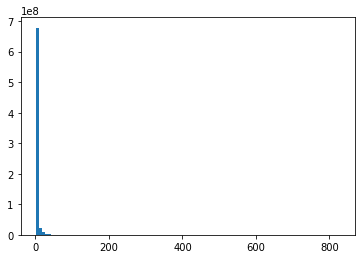

In [27]:
_ = plt.hist(counts, bins=100)

# Homework 1: Spark EDA

In [28]:
# TODO